## CHP Incident Data Analysis by Esther Yu

In [38]:
import numpy as np
import pandas as pd

In [39]:
headers = pd.read_csv('CHP_Headers.csv')
print(headers)

Empty DataFrame
Columns: [Incident ID, CC Code, Incident Number, Timestamp, Description, Location, Area, Zoom Map, TB XY, Latitude, Longitute, District, County FIPS ID, City FIPS ID, Freeway Number, Freeway Direction, State Post Mile, Absolute Post Mile, Severity, Duration]
Index: []


## Initial Data Understanding / Manipulation

In [40]:
column_names = headers.columns.values.tolist()
print(column_names)

['Incident ID', 'CC Code', 'Incident Number', 'Timestamp', 'Description', 'Location', 'Area', 'Zoom Map', 'TB XY', 'Latitude', 'Longitute', 'District', 'County FIPS ID', 'City FIPS ID', 'Freeway Number', 'Freeway Direction', 'State Post Mile', 'Absolute Post Mile', 'Severity', 'Duration']


In [41]:
## Day DFs
df1 = pd.read_csv('all_text_chp_incident_day_2022_05_01.csv', names=column_names)
df2 = pd.read_csv('all_text_chp_incident_day_2022_05_02.csv', names=column_names)
df3 = pd.read_csv('all_text_chp_incident_day_2022_05_03.csv', names=column_names)

## Month DFs
df4 = pd.read_csv('all_text_chp_incidents_month_2022_01.csv', names=column_names)
df5 = pd.read_csv('all_text_chp_incidents_month_2022_02.csv', names=column_names)
df6 = pd.read_csv('all_text_chp_incidents_month_2022_03.csv', names=column_names)
df7 = pd.read_csv('all_text_chp_incidents_month_2022_04.csv', names=column_names)

df_total = pd.concat([df1, df2, df3, df4, df5, df6, df7])

/var/folders/_f/_j0mb7bj5yb0d9rnntlgtz6w0000gn/T/ipykernel_27173/2618499473.py:7: DtypeWarning: Columns (0,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('all_text_chp_incidents_month_2022_01.csv', names=column_names)
/var/folders/_f/_j0mb7bj5yb0d9rnntlgtz6w0000gn/T/ipykernel_27173/2618499473.py:8: DtypeWarning: Columns (0,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df5 = pd.read_csv('all_text_chp_incidents_month_2022_02.csv', names=column_names)


In [42]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158468 entries, 0 to 40510
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Incident ID         158468 non-null  object 
 1   CC Code             158468 non-null  object 
 2   Incident Number     158465 non-null  float64
 3   Timestamp           158465 non-null  object 
 4   Description         158468 non-null  object 
 5   Location            158468 non-null  object 
 6   Area                157432 non-null  object 
 7   Zoom Map            3 non-null       float64
 8   TB XY               3 non-null       float64
 9   Latitude            157556 non-null  float64
 10  Longitute           157556 non-null  object 
 11  District            157455 non-null  float64
 12  County FIPS ID      157455 non-null  float64
 13  City FIPS ID        117687 non-null  float64
 14  Freeway Number      158465 non-null  float64
 15  Freeway Direction   157459 non-null

In [43]:
df_census_population = pd.read_csv('Census Population.csv')
df_area_mappings = pd.read_csv('CHP Area DMA Mapping.csv')

In [44]:
df_total['DMA'] = df_total['Area'].map(df_area_mappings.set_index('Area')['DMA'])
df_total['DMA Population'] = df_total['DMA'].map(df_census_population.set_index('DMA')['Census DMA Total Population'])

In [45]:
df_total = df_total[df_total["Incident ID"].str.contains('Jwo Hirschdale Ofr') == False]
df_total = df_total.astype({"Incident ID":'int', "Longitute":'float'})
print(df_total.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65533 entries, 0 to 32767
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Incident ID         65533 non-null  int64  
 1   CC Code             65533 non-null  object 
 2   Incident Number     65533 non-null  float64
 3   Timestamp           65533 non-null  object 
 4   Description         65533 non-null  object 
 5   Location            65533 non-null  object 
 6   Area                65059 non-null  object 
 7   Zoom Map            0 non-null      float64
 8   TB XY               0 non-null      float64
 9   Latitude            65121 non-null  float64
 10  Longitute           65121 non-null  float64
 11  District            65081 non-null  float64
 12  County FIPS ID      65081 non-null  float64
 13  City FIPS ID        48817 non-null  float64
 14  Freeway Number      65530 non-null  float64
 15  Freeway Direction   65068 non-null  object 
 16  Stat

In [46]:
df_total_clean = df_total.drop(columns=['Zoom Map', 'TB XY'])
df_total_clean = df_total_clean.dropna(subset=['DMA', 'DMA Population'])
df_total_clean = df_total_clean.rename(columns={'Longitute': 'Longitude'})

In [47]:
## Adding Time of the Day 'TOD' and Day of the Week 'DOW' based on 'Timestamp'

# TOD
import dateutil

def get_part_of_day(hour):
    return (
        "morning" if 6 <= hour <= 11
        else
        "afternoon" if 12 <= hour <= 17
        else
        "evening" if 18 <= hour <= 22
        else
        "night"
    )

df_total_clean['TOD'] = df_total_clean.Timestamp.apply(lambda x: get_part_of_day(dateutil.parser.parse(x).hour))

# DOW
df_total_clean['DOW'] = pd.to_datetime(df_total_clean['Timestamp']).dt.day_name()

In [48]:
cl_df_total_clean = list(df_total_clean.columns.values.tolist())

## Data Analysis / Visualization

In [49]:
import sklearn
# !python -m pip install -U matplotlib
import matplotlib.pyplot as plt
# !pip install seaborn
import seaborn as sns 
# !pip install plotly
import plotly 
import plotly.express as px 

In [50]:
df_dma_stats = df_total_clean.groupby("DMA").size().reset_index().rename(columns={0: "Incident Count"})
df_dma_stats['DMA Population'] = df_dma_stats['DMA'].map(df_census_population.set_index('DMA')['Census DMA Total Population'])
df_dma_stats['Incidents Per Capita'] = df_dma_stats['Incident Count'] / df_dma_stats['DMA Population']
df_dma_stats = df_dma_stats.sort_values(ascending=False, by='Incidents Per Capita')
df_dma_stats

,DMA,Incident Count,DMA Population,Incidents Per Capita
4,LOS ANGELES,34102,18391656,0.001854
9,SAN FRANCISCO-OAK-SAN JOSE,13251,7774401,0.001704
7,SACRAMNTO-STKTON-MODESTO,6579,4370160,0.001505
8,SAN DIEGO,4831,3269883,0.001477
1,CHICO-REDDING,686,467350,0.001468
5,MONTEREY-SALINAS,885,628002,0.001409
2,EUREKA,225,160295,0.001404
10,SANTABARBRA-SANMAR-SANLUOB,945,703584,0.001343
3,FRESNO-VISALIA,1713,2092085,0.000819
0,BAKERSFIELD,222,747772,0.000297


Text(0.5, 1.0, 'Figure 1: Incident Count by DMA')

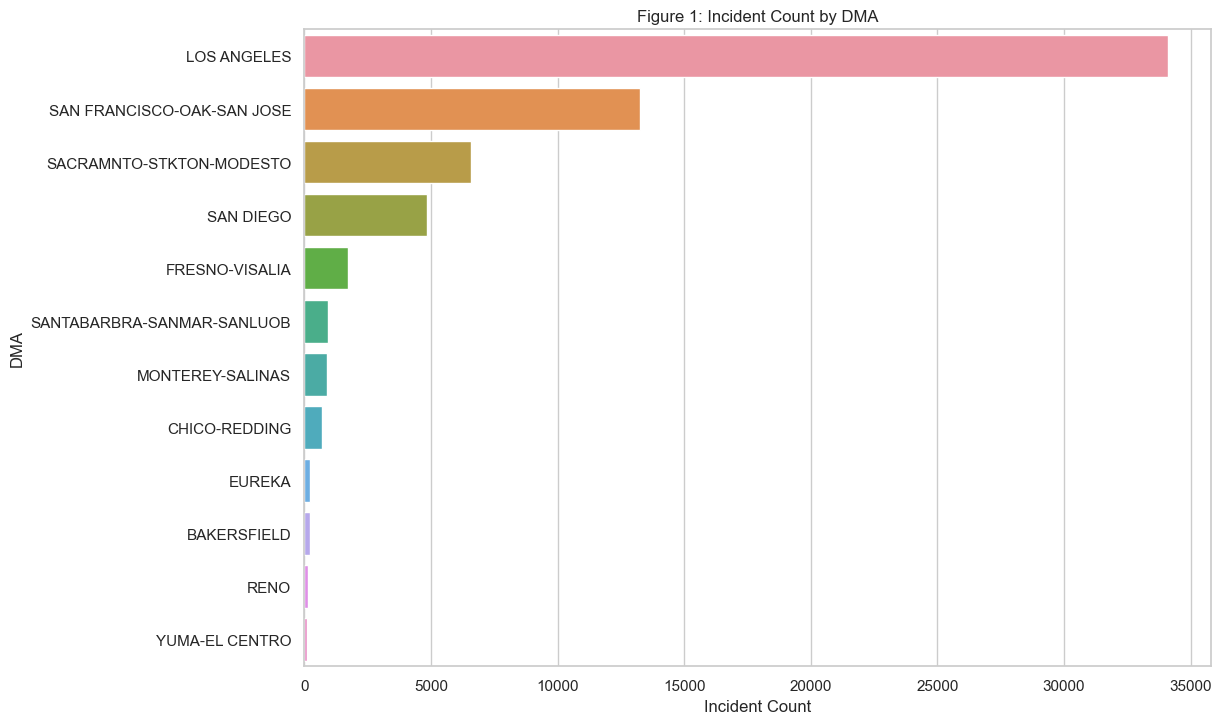

In [51]:
# plot the count by 'DMA'
sns.set_theme(style='whitegrid')
sns.barplot(y = 'DMA', 
            x = 'Incident Count',
            data = df_dma_stats,
            order = df_dma_stats.sort_values(by='Incident Count', ascending = False).DMA
           )
plt.title("Figure 1: Incident Count by DMA")



Text(0.5, 1.0, 'Figure 2: Incident Per Capita by DMA')

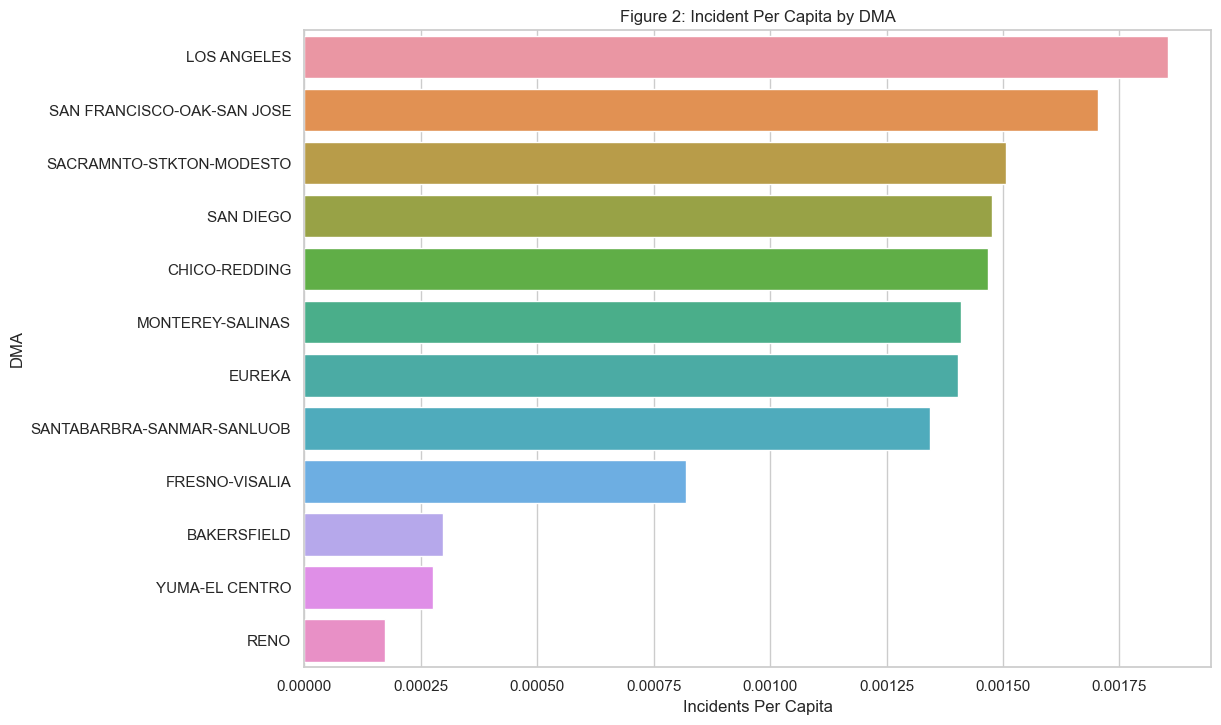

In [52]:
# plot the incident count by 'DMA
sns.barplot(y = 'DMA', 
            x = 'Incidents Per Capita',
            data = df_dma_stats,
            order = df_dma_stats.sort_values(by='Incidents Per Capita',ascending = False).DMA
           )
plt.title("Figure 2: Incident Per Capita by DMA")

In [53]:
correlation = df_dma_stats['Incidents Per Capita'].corr(df_dma_stats['DMA Population'])
print(f"The correlation between larger cities and higher incidents per capita is {round(correlation, 2)}")

The correlation between larger cities and higher incidents per capita is 0.53


In [54]:
df_total_clean

,Incident ID,CC Code,Incident Number,Timestamp,Description,Location,Area,Latitude,Longitude,District,...,Freeway Number,Freeway Direction,State Post Mile,Absolute Post Mile,Severity,Duration,DMA,DMA Population,TOD,DOW
0,20660604,GGHB,220101.0,01/01/2022 00:00:00,1183-Trfc Collision-Unkn Inj,Us101 N / Alum Rock Ave Ofr,San Jose,37.346961,-121.858883,4.0,...,101.0,N,R35.467,385.100,NaN,1065.0,SAN FRANCISCO-OAK-SAN JOSE,7774401.0,night,Saturday
1,20660606,INHB,220101.0,01/01/2022 00:04:00,WW-Wrong Way Driver,Sr241 S / Windy Ridge Toll Plaza,Santa Ana,33.824678,-117.716743,12.0,...,241.0,S,35.845,21.300,NaN,4.0,LOS ANGELES,18391656.0,night,Saturday
2,20660620,INHB,220101.0,01/01/2022 00:17:00,20002-Hit and Run No Injuries,I5 S / Kettner St Ofr,San Diego,32.743392,-117.184624,11.0,...,5.0,S,R18.409,18.300,NaN,58.0,SAN DIEGO,3269883.0,night,Saturday
3,20660622,GGHB,220101.0,01/01/2022 00:21:00,1183-Trfc Collision-Unkn Inj,Sr87 N / Taylor St Ofr,San Jose,37.342700,-121.901165,4.0,...,87.0,N,6.559,6.575,NaN,26.0,SAN FRANCISCO-OAK-SAN JOSE,7774401.0,night,Saturday
4,20660628,LAHB,220101.0,01/01/2022 00:15:00,1179-Trfc Collision-1141 Enrt,Sr90 W / Mindanao Way,West LA,33.983808,-118.437711,7.0,...,90.0,W,1.221,0.300,NaN,5.0,LOS ANGELES,18391656.0,night,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,20764024,GGHB,220225.0,02/25/2022 17:35:00,1183-Trfc Collision-Unkn Inj,I80 E / El Portal Dr Ofr,Oakland,37.964690,-122.324915,4.0,...,80.0,E,5.054,18.400,NaN,41.0,SAN FRANCISCO-OAK-SAN JOSE,7774401.0,afternoon,Friday
32764,20764025,GGHB,220225.0,02/25/2022 17:34:00,1182-Trfc Collision-No Inj,I880 N / Stevenson Blvd Ofr,Hayward FSP,37.520060,-121.983042,4.0,...,880.0,N,5.973,16.200,NaN,23.0,SAN FRANCISCO-OAK-SAN JOSE,7774401.0,afternoon,Friday
32765,20764027,LAHB,220225.0,02/25/2022 17:39:00,1182-Trfc Collision-No Inj,I105 E / Long Beach Blvd N Onr,LAFSP,33.921583,-118.202796,7.0,...,105.0,E,R12,12.000,NaN,45.0,LOS ANGELES,18391656.0,afternoon,Friday
32766,20764028,LAHB,220225.0,02/25/2022 17:35:00,1182-Trfc Collision-No Inj,I10 E / Dudley St Ofr,Baldwin Park,34.072742,-117.784012,7.0,...,10.0,E,43.9,42.400,NaN,112.0,LOS ANGELES,18391656.0,afternoon,Friday


In [55]:
# By 'Description'
sns.set(rc={'figure.figsize':(11.7,8.27)})

# summarize the count stats by 'Description' in df_desc_count
df_desc_count = df_total_clean['Description'].value_counts()
df_desc_count = pd.DataFrame(df_desc_count).reset_index()
df_desc_count.columns = ['Description', 'Count']
df_desc_count.head(10)


,Description,Count
0,1125-Traffic Hazard,31765
1,1183-Trfc Collision-Unkn Inj,8460
2,1182-Trfc Collision-No Inj,7415
3,1179-Trfc Collision-1141 Enrt,4169
4,20002-Hit and Run No Injuries,2938
5,FIRE-Report of Fire,2197
6,1125A-Animal Hazard,1038
7,CZP-Assist with Construction,899
8,CFIRE-Car Fire,836
9,BREAK-Traffic Break,578


Text(0.5, 1.0, 'Figure 3: Count by Incidents')

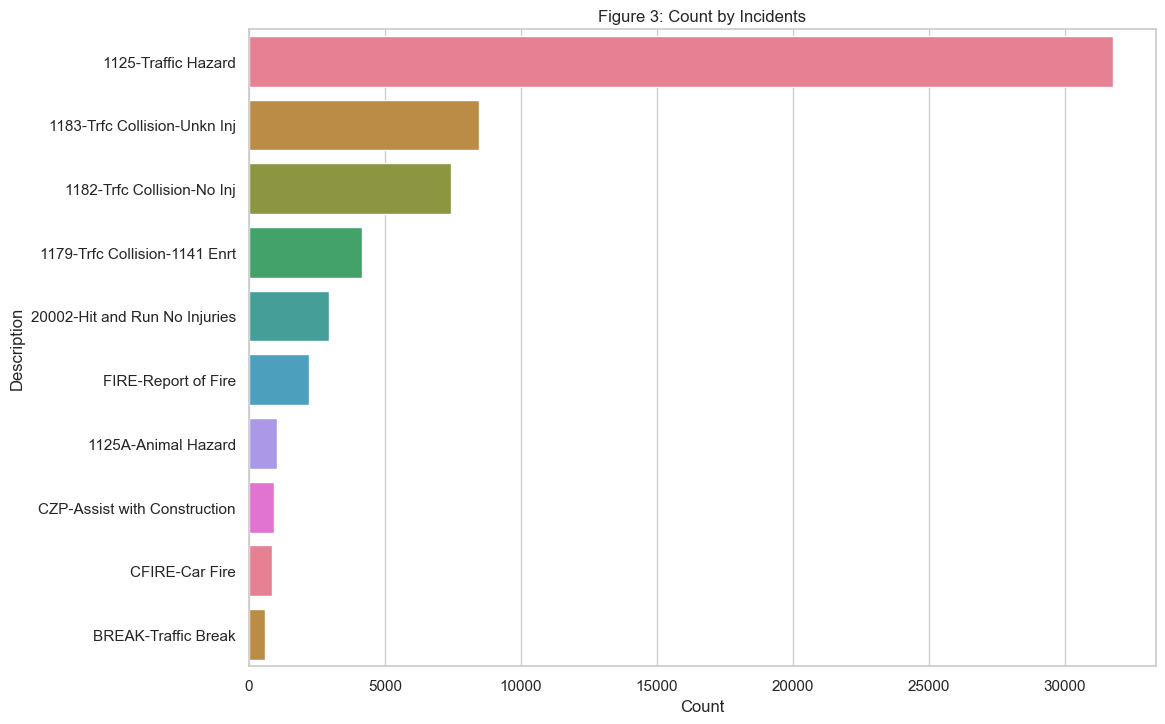

In [56]:
# plot the count by 'Description'

sns.set_theme(style='whitegrid')
sns.barplot(y = 'Description', 
            x = 'Count', 
            palette = sns.color_palette("husl", 8),
            data = df_desc_count[:10]
           )
plt.title("Figure 3: Count by Incidents")



In [57]:
df_injury = df_total_clean[df_total_clean['Description'] == "1179-Trfc Collision-1141 Enrt"]

In [58]:
df_dma_stats = df_injury.groupby("DMA").size().reset_index().rename(columns={0: "Incident Count"})
df_dma_stats['DMA Population'] = df_dma_stats['DMA'].map(df_census_population.set_index('DMA')['Census DMA Total Population'])
df_dma_stats['Incidents Per Capita'] = df_dma_stats['Incident Count'] / df_dma_stats['DMA Population']
df_dma_stats = df_dma_stats.sort_values(ascending=False, by='Incidents Per Capita')
df_dma_stats


,DMA,Incident Count,DMA Population,Incidents Per Capita
1,CHICO-REDDING,76,467350,0.000163
8,SAN DIEGO,416,3269883,0.000127
4,LOS ANGELES,2103,18391656,0.000114
9,SAN FRANCISCO-OAK-SAN JOSE,858,7774401,0.000110
7,SACRAMNTO-STKTON-MODESTO,431,4370160,0.000099
5,MONTEREY-SALINAS,60,628002,0.000096
10,SANTABARBRA-SANMAR-SANLUOB,67,703584,0.000095
2,EUREKA,11,160295,0.000069
3,FRESNO-VISALIA,107,2092085,0.000051
11,YUMA-EL CENTRO,9,383067,0.000023


Text(0.5, 1.0, 'Figure 4: Ambulance Enroute Incident Per Capita by DMA')

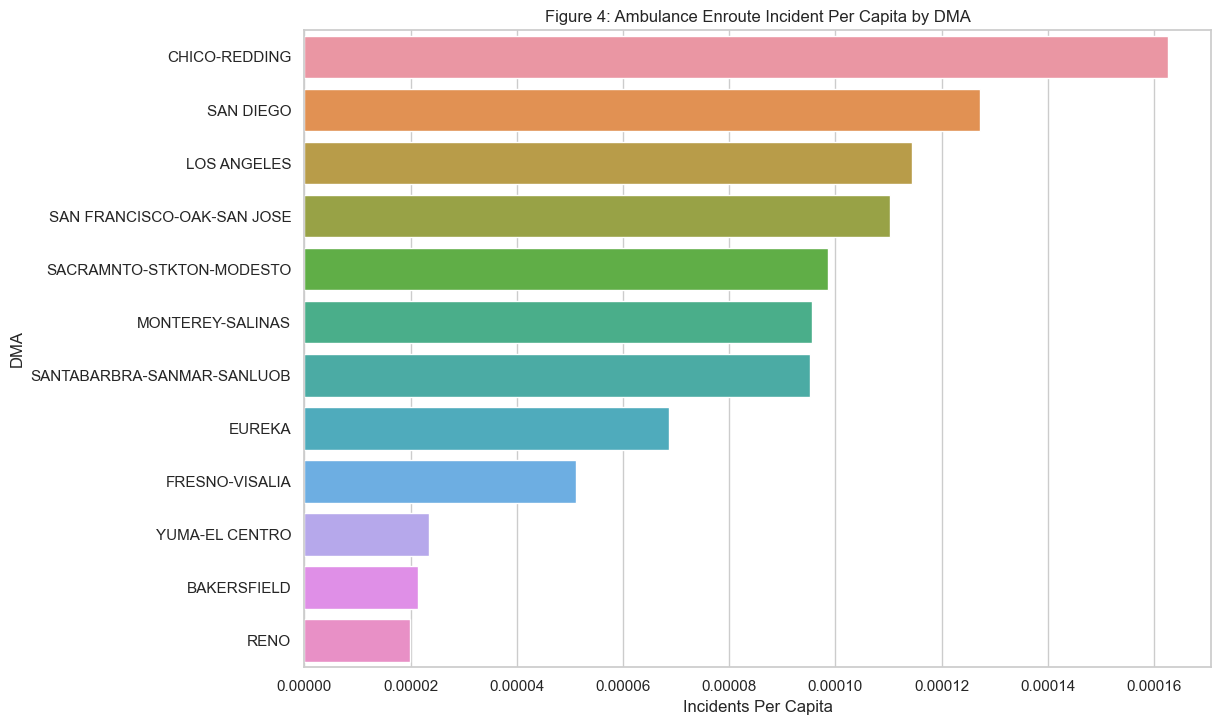

In [59]:
# plot the incident count by 'DMA
sns.barplot(y = 'DMA', 
            x = 'Incidents Per Capita',
            data = df_dma_stats,
            order = df_dma_stats.sort_values(by='Incidents Per Capita',ascending = False).DMA
           )
plt.title("Figure 4: Ambulance Enroute Incident Per Capita by DMA")

In [60]:
correlation = df_dma_stats['Incidents Per Capita'].corr(df_dma_stats['DMA Population'])
print(f"The correlation between larger cities and more injury incidents per capita is {round(correlation, 2)}")

The correlation between larger cities and more injury incidents per capita is 0.34


In [61]:
# By 'TOD'
df_TOD_count = df_total_clean['TOD'].value_counts()
df_TOD_count = pd.DataFrame(df_TOD_count).reset_index()
df_TOD_count.columns = ['TOD', 'Count']
#df_TOD_count['Percentage'] = (df_TOD_count['Count']/63676)*100
display(df_TOD_count)

# By 'TOD'
df_DOW_count = df_total_clean['DOW'].value_counts()
df_DOW_count = pd.DataFrame(df_DOW_count).reset_index()
df_DOW_count.columns = ['DOW', 'Count']
#df_DOW_count['Percentage'] = (df_DOW_count['Count']/63676)*100
display(df_DOW_count)

,TOD,Count
0,afternoon,24323
1,morning,19475
2,evening,11855
3,night,8023


,DOW,Count
0,Friday,10713
1,Wednesday,10230
2,Thursday,10085
3,Tuesday,10046
4,Monday,8242
5,Saturday,7757
6,Sunday,6603


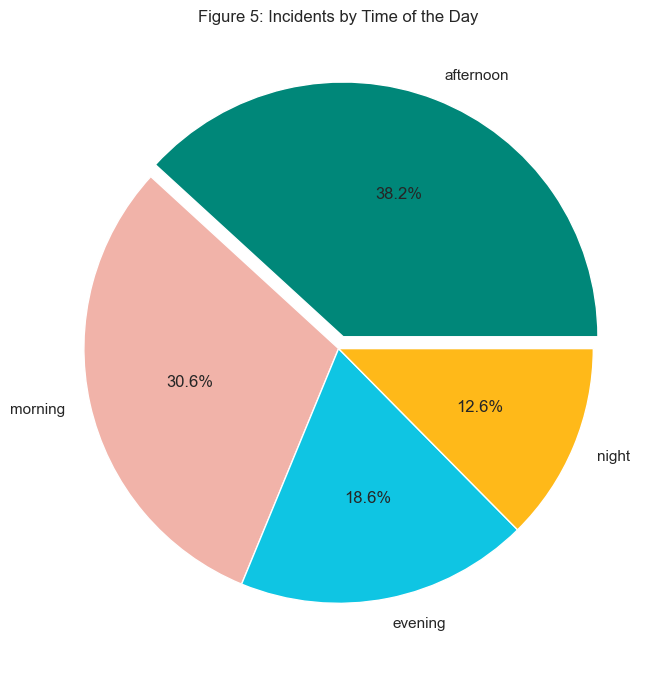

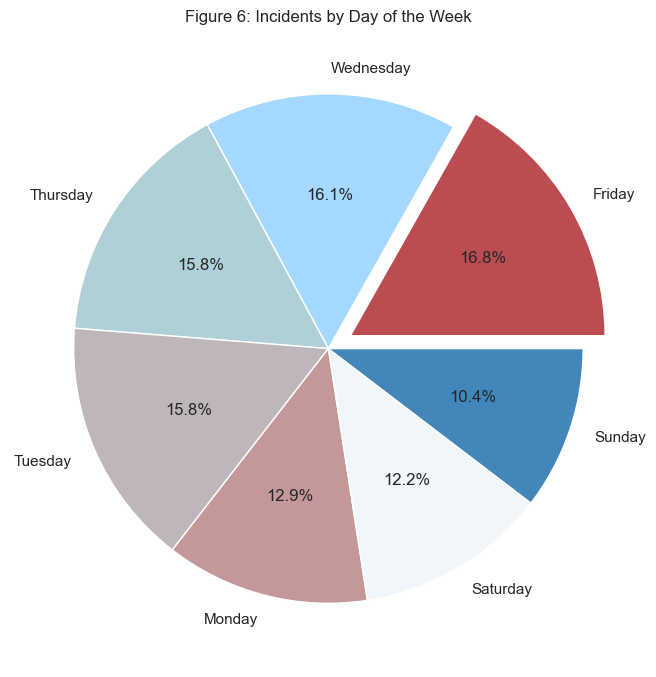

In [62]:
### Creating Pie Chart based on 'TOD' & 'DOW'

#'TOD'
colors = ['#008779', '#f1b3a9', '#0fc5e3', '#ffb919']
explode = (0.05, 0, 0, 0) 

plt.pie(df_TOD_count['Count'], labels=df_TOD_count['TOD'], explode = explode, colors = colors, autopct='%1.1f%%')
plt.title("Figure 5: Incidents by Time of the Day")
plt.show()

# 'DOW'
colors2 = ['#BB4C51', '#A5D8FF', '#AFD0D6', '#BFB6BB', '#C49799', '#F0F6FA', '#4286BA']
explode2 = (0.1, 0, 0, 0, 0, 0, 0) 

plt.pie(df_DOW_count['Count'], labels=df_DOW_count['DOW'], explode = explode2, colors = colors2, autopct='%1.1f%%')
plt.title("Figure 6: Incidents by Day of the Week")
plt.show()


## Data Modeling– Random Forest

In [63]:
df_total_clean.columns

Index(['Incident ID', 'CC Code', 'Incident Number', 'Timestamp', 'Description',
       'Location', 'Area', 'Latitude', 'Longitude', 'District',
       'County FIPS ID', 'City FIPS ID', 'Freeway Number', 'Freeway Direction',
       'State Post Mile', 'Absolute Post Mile', 'Severity', 'Duration', 'DMA',
       'DMA Population', 'TOD', 'DOW'],
      dtype='object')

In [64]:
data = df_total_clean.drop(columns=["Incident ID", "CC Code", "Incident Number", "Timestamp", "Area", "Latitude", "Longitude",
                            "District", "County FIPS ID", "City FIPS ID", "Severity", "Duration"])

not_severe_labels = ["1182-Trfc Collision-No Inj", "20002-Hit and Run No Injuries"]
severe_labels = ["1179-Trfc Collision-1141 Enrt", "FIRE-Report of Fire", "CFIRE-Car Fire"]
labels = not_severe_labels + severe_labels

In [65]:
data = data[data["Description"].isin(labels)]
data['Severe'] = data["Description"].apply(lambda x: x in severe_labels)
data = data.dropna()

In [66]:
data['Severe'].value_counts()

False    10325
True      7175
Name: Severe, dtype: int64

In [67]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

data['Location'] = le.fit_transform(data['Location'])
data['Freeway Direction'] = le.fit_transform(data['Freeway Direction'])
data['State Post Mile'] = le.fit_transform(data['State Post Mile'])
data['DMA'] = le.fit_transform(data['DMA'])
data['TOD'] = le.fit_transform(data['TOD'])
data['DOW'] = le.fit_transform(data['DOW'])

In [68]:
data['State Post Mile']

2        4836
4         135
7        1093
12       3793
15        963
         ... 
32759    4919
32760    4925
32764    3227
32765    4430
32766    2951
Name: State Post Mile, Length: 17500, dtype: int64

In [69]:
X = data.drop(columns=["Severe", "Description"])
y = data["Severe"]

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [71]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.615618067625227

In [72]:
features_to_importance = list(zip(X_train.columns, clf.feature_importances_))
features_to_importance.sort(key=lambda x: x[1], reverse=True)

for feature, score in features_to_importance:
    print(f"{feature}: {score}")

Absolute Post Mile: 0.20431392803018267
State Post Mile: 0.18094944555033035
Location: 0.1806550086734643
TOD: 0.14402690398988574
DOW: 0.09225987254234536
Freeway Number: 0.07447771868187684
DMA Population: 0.05422965123094986
Freeway Direction: 0.034715431510058695
DMA: 0.03437203979090623


## Heatmap for Fun

In [73]:
### Creating Heatmap
!pip install folium
import folium                    
import folium.plugins as plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime


In [83]:
def generateBaseMap(default_location=[36.778259,-119.417931], default_zoom_start=6.2):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map = generateBaseMap()
base_map

m = HeatMap(data=df_total_clean[['Latitude', 'Longitude', 'Incident ID']].groupby(['Latitude','Longitude']).sum().reset_index().values.tolist(), radius=7, max_zoom=10).add_to(base_map)

m.save('heatmap.html')

from IPython.display import IFrame
IFrame(src='./heatmap.html', width=700, height=450)